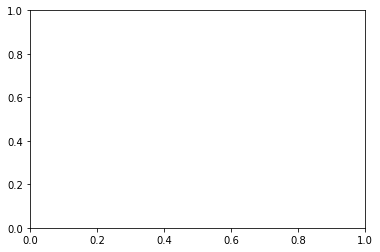

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from navipy.trajectories.similarity.frechet import frdist
import numpy as np

## Trajectories

We load two trajectories from the resampled trajecotries of bees in a cluttered environment.

Text(0, 0.5, 'y [mm]')

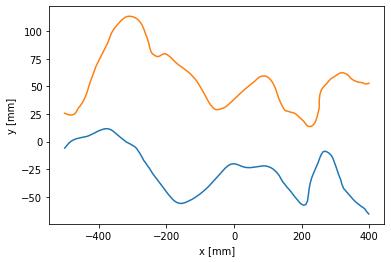

In [2]:
hdf_file = 'data_all.hdf' # path to the data file
conditions = pd.read_hdf(hdf_file, key='conditions') # read conditions-table from hdf file
traj_dates = conditions['Filename'] # get the dates for the trajectories from the conditions-table
# we will load the trajectory with the dates and the following prefix as key from the hdf file
key_template = 'traj_coeff_{}' # will be used as: key_template.format(date)
# Two trajectories
traj1 = pd.read_hdf(hdf_file, key=key_template.format(traj_dates[0]))
traj2 = pd.read_hdf(hdf_file, key=key_template.format(traj_dates[17]))
# for our result, we only use x and y coordinates
traj1 = traj1.loc[:, ['x', 'y']].astype(float) 
traj2 = traj2.loc[:, ['x', 'y']].astype(float) 

plt.plot(traj1.x,traj1.y)
plt.plot(traj2.x,traj2.y)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

## DTW and Frechet

In [3]:
def euclidean_norm(x, y): 
    return np.sqrt(np.sum((x - y) ** 2))
distdtw, frame_match = fastdtw(traj1, traj2, dist=euclidean_norm)

In [4]:
distfrechet, frame_match_frechet = frdist2(traj1, traj2, dist=euclidean_norm)
frame_match_frechet = frame_match_frechet.astype(int)

## Illustrate

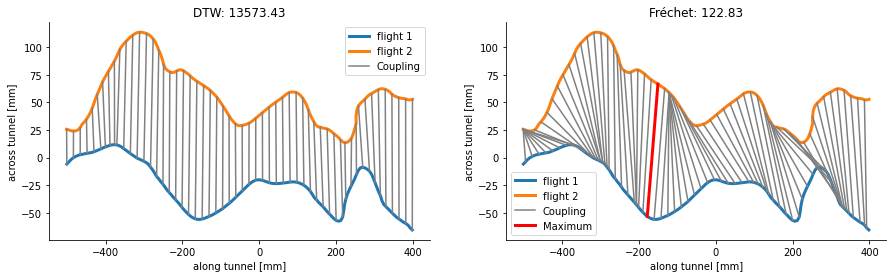

In [5]:
fig, axarr = plt.subplots(1,2, figsize=(15,4))

ax=axarr[0]
ax.plot(traj1.x,traj1.y, lw=3, label='flight 1')
ax.plot(traj2.x,traj2.y, lw=3, label='flight 2')
for i, match in enumerate(frame_match[::3]):
    ax.plot([traj1.x.iloc[match[0]],traj2.x.iloc[match[1]]],
            [traj1.y.iloc[match[0]],traj2.y.iloc[match[1]]], 'gray',
            label="Coupling" if i == 0 else "")
ax.set_title('DTW: {:.2f}'.format(distdtw))
ax.legend()
ax=axarr[1] 
ax.plot(traj1.x,traj1.y, lw=3, label='flight 1')
ax.plot(traj2.x,traj2.y, lw=3, label='flight 2')
eps = 0.1 # Adjust to get one
for i, (_, match) in enumerate(frame_match_frechet.iloc[::3,:].iterrows()):
    if np.abs((euclidean_norm(traj1.iloc[match.pi],traj2.iloc[match.qi]) - distfrechet))>eps:
        ax.plot([traj1.x.iloc[match.pi],traj2.x.iloc[match.qi]],
                [traj1.y.iloc[match.pi],traj2.y.iloc[match.qi]], 'gray',
                label="Coupling" if i == 0 else "")
    else:
        ax.plot([traj1.x.iloc[match.pi],traj2.x.iloc[match.qi]],
                [traj1.y.iloc[match.pi],traj2.y.iloc[match.qi]], 'red', lw=3, 
                label="Maximum")
ax.set_title('Fréchet: {:.2f}'.format(distfrechet))
ax.legend()
for ax in axarr:
    ax.set_xlabel('along tunnel [mm]')
    ax.set_ylabel('across tunnel [mm]')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
fig.savefig('figures/chap01b_ExampleDTW_Frechet.svg')
fig.savefig('figures/chap01b_ExampleDTW_Frechet.png')